In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
import tensorflow as tf
import sys

### Data Representations
* Much easier to remember *sequence patterns* than to remember exact lists. First studied as chess game positions (1970s).
* Autoencoder converts inputs to internal shorthand, then returns best-guess similarity. Two parts: *encoder* (recognizer) & *decoder* (generator, aka *reconstructor*).
* Reconstruction loss - penalizes model when reconstructions /= inputs.
* Internal representation = lower dimensionality, so AE is forced to learn most important features in inputs.

### PCA with Undercomplete Linear Autoencoder

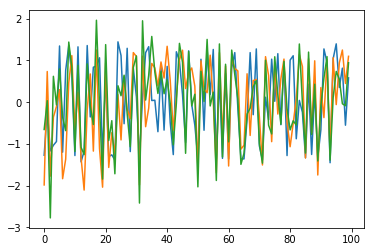

In [2]:
# lets build a 3D dataset

rnd.seed(4)
m = 100
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
X_train = np.empty((m, 3))
X_train[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
X_train[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
X_train[:, 2] = X_train[:, 0] * w1 + X_train[:, 1] * w2 + noise * rnd.randn(m)

# normalize it

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

plt.plot(X_train)
plt.show()

In [3]:
# build AE

from tensorflow.contrib.layers import fully_connected

n_inputs = 3 # 3D inputs
n_hidden = 2 # 2D codings
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(
    tf.float32, shape=[None, n_inputs])

#
# set activation_fn=None & use MSE for cost function
# to perform simple PCA.
#

hidden = fully_connected(
    X, 
    n_hidden, 
    activation_fn=None)

outputs = fully_connected(
    hidden, 
    n_outputs, 
    activation_fn=None)

# MSE
reconstruction_loss = tf.reduce_mean(
    tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(
    learning_rate)

training_op = optimizer.minimize(
    reconstruction_loss)

init = tf.global_variables_initializer()

In [4]:
# run the AE

n_iterations = 10000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_train})

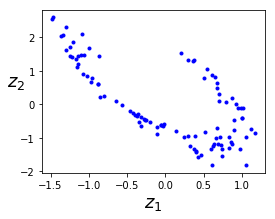

In [5]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
#ave_fig("linear_autoencoder_pca_plot")
plt.show()

# plot: 2D projection with max variance

### Stacked Autoencoders
* AEs with multiple hidden layers - for more complex model learning
![stacked-AE](pics/stacked-AE.png)

In [6]:
tf.reset_default_graph()

n_inputs      = 28 * 28 # for MNIST
n_hidden1     = 300
n_hidden2     = 150 # codings
n_hidden3     = n_hidden1
n_outputs     = n_inputs
learning_rate = 0.01
l2_reg        = 0.0001

X = tf.placeholder(tf.float32, 
                   shape=[None, n_inputs])

with tf.contrib.framework.arg_scope(
    [fully_connected],
    activation_fn=tf.nn.elu,
    weights_initializer=tf.contrib.layers.variance_scaling_initializer(),
    weights_regularizer=tf.contrib.layers.l2_regularizer(l2_reg)):

    hidden1 = fully_connected(X,       n_hidden1)
    hidden2 = fully_connected(hidden1, n_hidden2) # codings
    hidden3 = fully_connected(hidden2, n_hidden3)
    outputs = fully_connected(hidden3, n_outputs, activation_fn=None)

# MSE
reconstruction_loss = tf.reduce_mean(
    tf.square(outputs - X))

reg_losses = tf.get_collection(
    tf.GraphKeys.REGULARIZATION_LOSSES)

loss = tf.add_n(
    [reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(
    learning_rate)

training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [7]:
# use MNIST dataset 

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

# train the net. digit labels (y_batch) = unused.

n_epochs = 4
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        mse_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", mse_train)
        saver.save(sess, "./my_model_all_layers.ckpt")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
0 Train MSE: 0.02705
1 Train MSE: 0.0137857
2 Train MSE: 0.0113694
3 Train MSE: 0.0107478


In [8]:
# utility: plot grayscale 28x28 image

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    

In [9]:
# load model, eval on test set (measure reconstruction error, display original & reconstruction)

def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

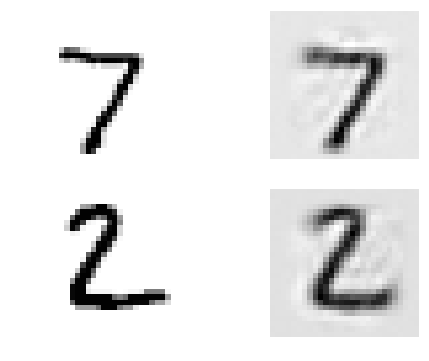

In [10]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")
plt.show()

### Tying Weights
* Used when AE is symmetrical. Tying decoder layer weights to encoder layers' weights cuts number of weights by 50% (speedup & less memory).
* Tied weights in TF is cumbersome. Easier to define layers manually.

In [11]:
tf.reset_default_graph()

activation = tf.nn.elu

regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
# weights 3,4 not vars!
weights3 = tf.transpose(weights2, name="weights3") # tied weights
weights4 = tf.transpose(weights1, name="weights4") # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1),name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2),name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3),name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs),name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(
    tf.square(outputs - X))

reg_loss = regularizer(weights1) + regularizer(weights2)

loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)

training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

### Training one Autoencoder at a time
* Often faster to train each shallow AE individually, then stack them.
* Simplest approach = use separate TF graph for each phase

![one-ae-atatime](pics/training-one-AE-atatime.png)

In [12]:
def train_autoencoder(
    X_train, 
    n_neurons, 
    n_epochs, 
    batch_size, 
    learning_rate = 0.01, 
    l2_reg = 0.0005, 
    activation_fn=tf.nn.elu):
    
    graph = tf.Graph()
    with graph.as_default():
        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        with tf.contrib.framework.arg_scope(
            [fully_connected],
            activation_fn=activation_fn,
            weights_initializer=tf.contrib.layers.variance_scaling_initializer(),
            weights_regularizer=tf.contrib.layers.l2_regularizer(
                l2_reg)):
            hidden = fully_connected(
                X, n_neurons, scope="hidden")
            outputs = fully_connected(
                hidden, n_inputs, activation_fn=None, scope="outputs")

        mse = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(
            tf.GraphKeys.REGULARIZATION_LOSSES)
        
        loss = tf.add_n([mse] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                
                indices = rnd.permutation(
                    len(X_train))[:batch_size]
                
                X_batch = X_train[indices]
                
                sess.run(
                    training_op, feed_dict={X: X_batch})
                
            mse_train = mse.eval(
                feed_dict={X: X_batch})
            
            print("\r{}".format(epoch), "Train MSE:", mse_train)
            
        params = dict(
            [(var.name, var.eval()) for var in tf.get_collection(
                tf.GraphKeys.TRAINABLE_VARIABLES)])
        
        hidden_val = hidden.eval(
            feed_dict={X: X_train})
        
        return hidden_val, params["hidden/weights:0"], params["hidden/biases:0"], params["outputs/weights:0"], params["outputs/biases:0"]

In [13]:
# train two AEs

hidden_output, W1, b1, W4, b4 = train_autoencoder(
    mnist.train.images, 
    n_neurons=300, 
    n_epochs=4, 
    batch_size=150)

_, W2, b2, W3, b3 = train_autoencoder(
    hidden_output, 
    n_neurons=150, 
    n_epochs=4, 
    batch_size=150)


0 Train MSE: 0.0193591
1 Train MSE: 0.0190697
2 Train MSE: 0.0188801
3 Train MSE: 0.0192353
0 Train MSE: 0.00428287
1 Train MSE: 0.00438113
2 Train MSE: 0.00464872
3 Train MSE: 0.00457076


In [15]:
# create stacked AE by reusing weights &and biases from above

tf.reset_default_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

### Visualizing Reconstructions

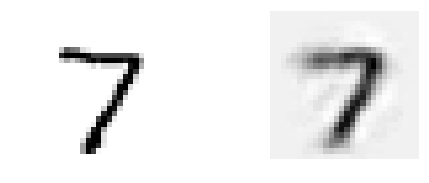

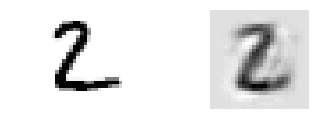

In [19]:
# Load model, evaluates it on test set (reconstruction error)
# display original & reconstructed images

def show_reconstructed_digits(
    X, 
    outputs, 
    model_path = None, 
    n_test_digits = 2):
    
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
            
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    
    for digit_index in range(n_test_digits):
        
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])
        plt.show()
        
#show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")
show_reconstructed_digits(X, outputs)

### Visualizing Features
* simplest method: find training instances that activate each hidden node the most. (best on upper layers, given their tendency to capture high-level features.)

### Unsupervised Pretraining with Stacked Autoencoders

### Denoising Autoencoders

### Sparse Autoencoders

### Variational Autoencoders

### Other Autoencoders